In [1]:
import pyemma
import numpy as np
import mdtraj as md
%pylab inline
from sklearn.decomposition import PCA
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from MDAnalysis.lib.distances import calc_angles

trajfile = '/home/dldx/gromacs/R-H/new-H_bound/equilibrium_combine.xtc'
topfile = '/home/dldx/gromacs/R-H/new-H_bound/H-bound.pdb'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

In [3]:
def compute_center_of_mass(traj,atom_indices=None):
    if atom_indices==None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)
    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [4]:
def angle(trajfile,topfile,list1,list2,list3):
    top_h = md.load(topfile) 
    traj = md.load(trajfile, top=top_h)
    mass1 = compute_center_of_mass(traj,list1).astype(np.float32)
    mass2 = compute_center_of_mass(traj,list2).astype(np.float32)
    mass3 = compute_center_of_mass(traj,list3).astype(np.float32)
    angle_list = []
    angles = calc_angles(mass1,mass2,mass3)
    angle_list.append(angles)
    return  angle_list

In [5]:
# H_open mdtraj FEL
# v1/v2(LNC - YRL)  98-168  原子791-1361    
# v3(PNN - RQA)   274-303   原子2153-2380
# β20 -β21 (QIV-AMY) 391-404     
# α1 (DMV-QSL) 68-85   
list1 = []
list2 = []
list3 = [] 

for i in range(98,169):
    list1.append(i)
for j in range(391,405):
    list2.append(j)
for k in range(68,86):
    list3.append(k)
    
top_h = md.load(topfile)
traj = md.load(trajfile,  top=top_h)
top_h_bb = top_h.topology.select('backbone')
rmsd = md.rmsd(traj, top_h, atom_indices=top_h_bb)

x_rmsd = rmsd
y_angle = angle(trajfile,topfile,list1,list2,list3)

In [6]:
#定义轨迹数据源
Y = []
for i in range(0,100001):
    Y.append([x_rmsd[i],y_angle[0][i]])
Y = np.array(Y)

<ipython-input-7-57deef3a240d>:6: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)


(0.0, 2.0)

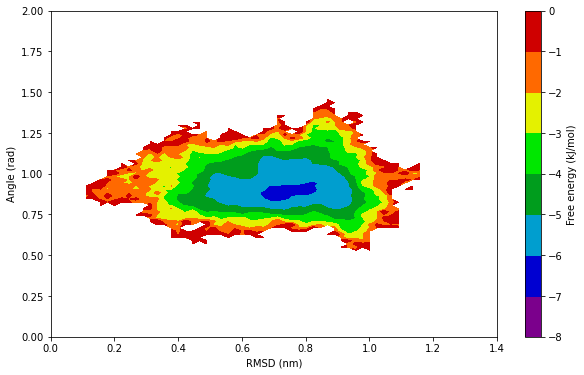

In [7]:
# histogram data
figure(figsize(10,6))
z,x,y = np.histogram2d(x_rmsd,y_angle[0], bins=50)

# F = -2.5*np.log(z)
F = -np.log(z)
extent = [x[0], x[-1], y[0], y[-1]]

levels = [i for i in range(-8,0,1)]+[0]
contourf(F.T, 15, cmap=cm.get_cmap("nipy_spectral"),levels=levels,extent=extent)

clb = colorbar()
clb.set_label('Free energy (kJ/mol)')
xlabel('RMSD (nm)')
ylabel('Angle (rad)')
xlim(0.0,1.4)
ylim(0.0,2.0)
# savefig('H-open_FEL.jpg',dpi=600,bbox_inches='tight')

13-10-22 19:23:20 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


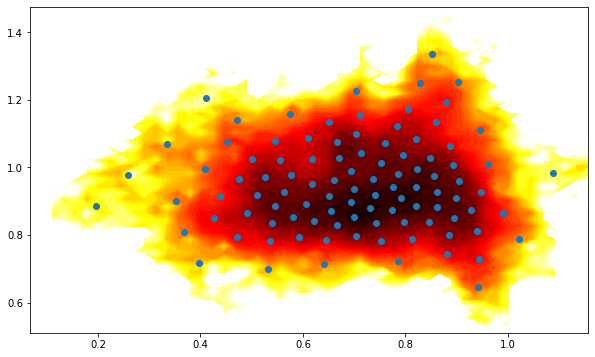

In [8]:
# k均值聚类  
# 参数： data为数据，k为聚类中心的数量， stride为步幅(int，可选，默认值 = 1）(如果设置为 1，则所有输入数据将用于估计。)   
# cl为返回的kmeans聚类对象,保存离散轨迹和聚类中心信息
cl = coor.cluster_kmeans(data=Y, k=100, stride=1)
# print(cl)

# for later use we save the discrete trajectories and cluster center coordinates:
#离散轨迹（将数据分配给聚类中心），聚类算法的主要结果是离散轨迹
#这是一个整数数组列表，每个使用的轨迹一个（这里只有一个）。对于每个 MD 轨迹帧，整数数组包含一个介于 0 和 99 之间的数字（因为我们使用了 100 个聚类中心）
dtrajs = cl.dtrajs

#包含计算的聚类中心的坐标的数组
cc_x = cl.clustercenters[:,0]
# print(cc_x)
cc_y = cl.clustercenters[:,1]

#作图
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

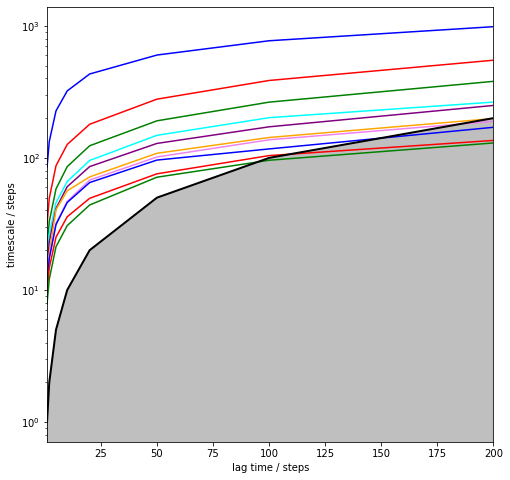

In [9]:
#msm估计

# 马尔可夫模型的质量和实际用途取决于两个主要参数：
# 1、状态空间离散化，即我们之前执行过哪些步骤（坐标选择，投影方法，聚类方法）
# 2、延迟时间，即我们在哪个时间计算转换。

#msm对象，它将使我们能够访问各种有趣的量。我们需要输入的是从聚类中获得的离散轨迹和滞后时间


#简而言之：更长的时间尺度更好，至少只要你远离灰色地带。灰色区域由滞后>时间尺度定义，在这方面，我们无法做出可靠的估计，因为正在调查的过程已经衰减。灰色区域内或附近的一切都被扭曲了。

figure(figsize=(8,8))
lags = [1,2,5,10,20,50,100,200]
#马尔可夫状态模型在一系列滞后时间估计的隐含时间尺度
#参数：dtrajs离散轨迹，lags整数滞后时间，在该时间段将计算隐含的时间刻度。
its = msm.its(dtrajs, lags=lags, nits=10,show_progress=False)
# # print(dtrajs)
# # print(its.timescales)
mplt.plot_implied_timescales(its)

In [10]:
#从离散轨迹估计马尔可夫模型，包含 MSM 和估计信息的估计器对象
# 参数为 离散轨迹和滞后时间
M = msm.estimate_markov_model(dtrajs, 100)

#最大连接集中的状态分数。
print('fraction of states used = ', M.active_state_fraction)
#最大连接集中的计数分数。
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


13-10-22 19:23:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


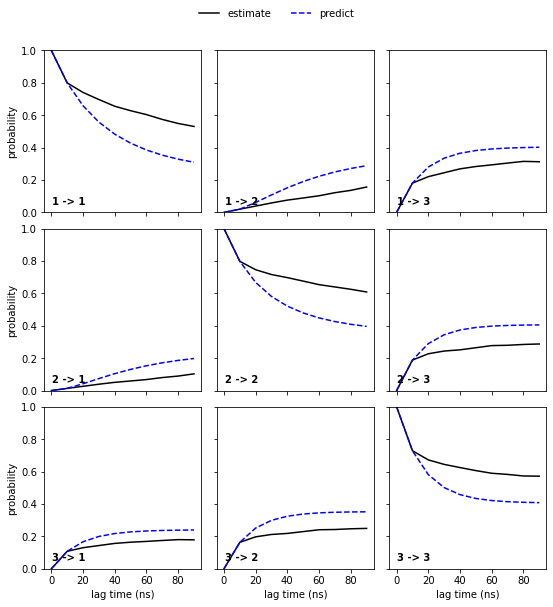

In [11]:
# cktest
test_cl = coor.cluster_kmeans(data=Y, k=3, stride=1)
test_dtrajs = test_cl.dtrajs
M_test = msm.estimate_markov_model(test_dtrajs, 100)

nstates = 3
cktest = M_test.cktest(nstates, mlags=10)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')
savefig('H_cktest.jpg',dpi=600,bbox_inches='tight')



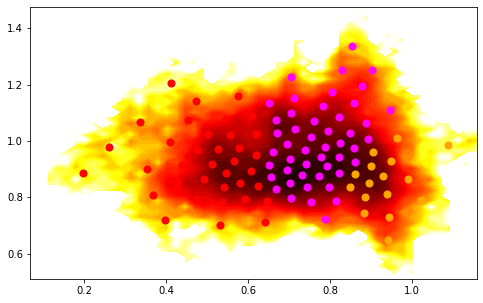

In [13]:
# PCCA，三个亚稳集
r_pcca = M.pcca(3)
pcca_sets_3 = M.metastable_sets

figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
size = 50
cols = ['orange', 'magenta', 'red', 'black', 'blue',]
for i in range(3):
    scatter(cc_x[pcca_sets_3[i]], cc_y[pcca_sets_3[i]], color=cols[i], s=size)

In [14]:
#选择这 3个集合中最左边和最右边的两个结束状态。由于亚稳表集的顺序在不同的运行中可能不同，我们实际上计算它们沿第一个PCA坐标的平均位置
xavg = avg_by_set(cc_x, pcca_sets_3)
A = pcca_sets_3[xavg.argmax()]
B = pcca_sets_3[xavg.argmin()]

#计算过渡路径
fluxAB = msm.tpt(M, A, B)

<Figure size 576x360 with 0 Axes>

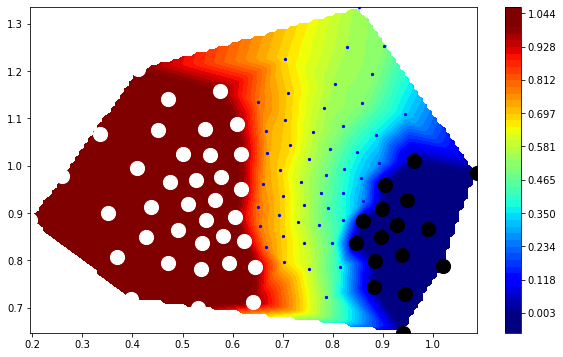

In [15]:
figure(figsize=(8,5))
mplt.scatter_contour(cl.clustercenters[:,0], cl.clustercenters[:,1], fluxAB.committor, colorbar=True, ncontours=15)
scatter(cl.clustercenters[A,0], cl.clustercenters[A,1], color='black', s=200)
scatter(cl.clustercenters[B,0], cl.clustercenters[B,1], color='white', s=200)

In [16]:
cg, cgflux = fluxAB.coarse_grain(pcca_sets)

# compute mean positions of sets. This is important because of some technical points the set order
# in the coarse-grained TPT object can be different from the input order.
avgpos = np.zeros((3,2))
avgpos[:,0] = avg_by_set(cc_x, cg)
avgpos[:,1] = avg_by_set(cc_y, cg)

In [17]:
# 3个聚类中心的概率
cgflux.stationary_distribution

array([0.14508788, 0.58285694, 0.27205518])

<ipython-input-18-2390f8993b38>:3: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)
<ipython-input-18-2390f8993b38>:22: UserWarning: The following kwargs were not used by contour: 'fig'
  cf=contourf(F.T, 50, cmap=cm.get_cmap("nipy_spectral"), extent=extent, fig=fig, zorder=0)


NameError: name 'cmp' is not defined

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


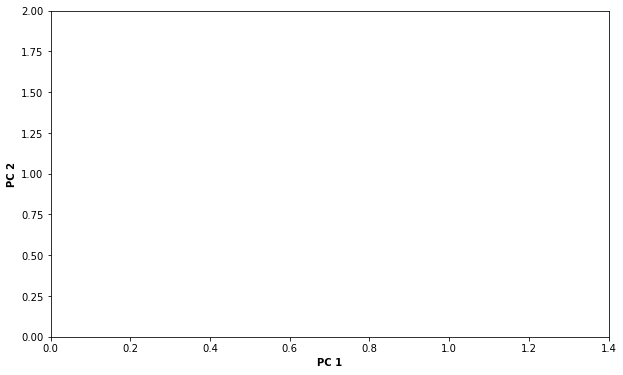

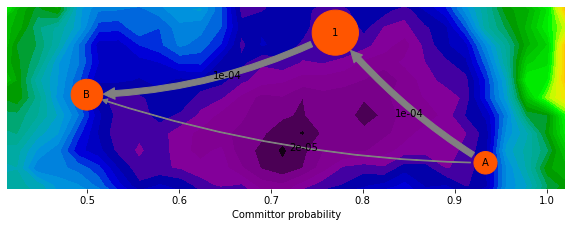

In [18]:
z,x,y = np.histogram2d(x_rmsd,y_angle[0], bins=50)

F = -np.log(z)
extent = [x[0], x[-1], y[0], y[-1]]

levels = [i for i in range(-8,0,1)]+[0]
# contourf(F.T, 15, cmap=cm.get_cmap("nipy_spectral"),levels=levels,extent=extent)

font={'size':13,
     'family':'Times New Roman',
     'weight':'bold',}
# clb = colorbar()
clb.set_label('Free Eigenvalue (KJ/mol)')
xlabel('PC 1',family='times new roman',weight='bold')
xlim(0.0,1.4)
ylim(0.0,2.0)
ylabel('PC 2',family='times new roman',weight='bold')

fig, _ = mplt.plot_flux(cgflux, avgpos, cgflux.stationary_distribution, max_width=10, max_height=7)
# clb = colorbar()
# cf=contourf(F.T, 50, cmap=cmap, extent=extent, fig=fig, zorder=0,levels=[i for i in range(-12,0,1)]+[0])
cf=contourf(F.T, 50, cmap=cm.get_cmap("nipy_spectral"), extent=extent, fig=fig, zorder=0)
contourf(F.T, 15, cmap=cmp,levels=levels,extent=extent)
# fig.set_size_inches(12, 4)

In [19]:
avgpos

array([[0.93353176, 0.85115415],
       [0.770087  , 0.99652904],
       [0.49972975, 0.92723697]])

percentage       	path
-------------------------------------
0.8891290585595365  	 [0 1 2]
0.11087094144046349  	 [0 2]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

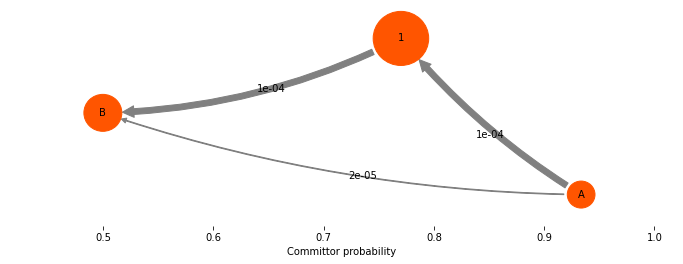

In [20]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print((path_fluxes[i] / np.sum(path_fluxes)),' \t', paths[i])
    
fig, _ = mplt.plot_flux(cgflux, avgpos, cgflux.stationary_distribution, minflux=1e-6)
clb = colorbar()
cf = contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, fig=fig, zorder=0)
fig.set_size_inches(12, 4)

# 0.14508788, 0.58285694, 0.27205518
# 0 1 2

In [34]:
#根据聚类cl的查找索引
# [0.93604279, 0.84817481],
# [0.7626307 , 0.97789621],
# [0.48396346, 0.92649978]

# print(Y)
# print(Y[1][0])
# print(Y[1][1])
for i in range(0,100001):
#     if Y[i][0] >= 0.93 and Y[i][0] <=0.94 and Y[i][1] >= 0.84 and Y[i][1] <= 0.85:
#         print("属于第一个中心集得索引为:" + str(i))
#     if Y[i][0] >= 0.76 and Y[i][0] <=0.77 and Y[i][1] >= 0.97 and Y[i][1] <= 0.98:
#         print("属于第二个中心集得索引为:" + str(i))
    if Y[i][0] >= 0.48 and Y[i][0] <=0.49 and Y[i][1] >= 0.92 and Y[i][1] <= 0.93:
        print("属于第三个中心集得索引为:" + str(i))
# print(Y[34231])

属于第三个中心集得索引为:3932
属于第三个中心集得索引为:3945
属于第三个中心集得索引为:4055
属于第三个中心集得索引为:11133
属于第三个中心集得索引为:11521
属于第三个中心集得索引为:12648
属于第三个中心集得索引为:12649
属于第三个中心集得索引为:12672
属于第三个中心集得索引为:20779
属于第三个中心集得索引为:21070
属于第三个中心集得索引为:21100
属于第三个中心集得索引为:21119
属于第三个中心集得索引为:30660
属于第三个中心集得索引为:41190
属于第三个中心集得索引为:41195
属于第三个中心集得索引为:43337
属于第三个中心集得索引为:51384
属于第三个中心集得索引为:51419
属于第三个中心集得索引为:60289
属于第三个中心集得索引为:80301
属于第三个中心集得索引为:80513
属于第三个中心集得索引为:90603
属于第三个中心集得索引为:90612
属于第三个中心集得索引为:91230
属于第三个中心集得索引为:92877


In [39]:
Y[20779]

array([0.48552039, 0.92320678])

In [40]:
#根据索引找到轨迹中的pdb
pdb = traj[20779]
pdb.save_pdb("/home/dldx/machine learning/FEL/H_o/r3/"+str(20779)+".pdb")